In [ ]:
from google.colab import drive
# 挂载谷歌云盘
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# 指定.zip文件路径
zip_file_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data.zip'

# 指定解压目标文件夹路径
target_folder_path = '/content/drive/MyDrive/ipen5810_miniproject2'

# 检查目标文件夹是否存在，如果不存在，则创建
if not os.path.exists(target_folder_path):
    os.makedirs(target_folder_path)

# 使用zipfile模块解压文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder_path)

print(f'文件已解压到 {target_folder_path}')


文件已解压到 /content/drive/MyDrive/ipen5810_miniproject2


In [ ]:
import zipfile
import os

# 指定.zip文件路径
zip_file_path = '/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile.zip'

# 指定解压目标文件夹路径
target_folder_path = '/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile'

# 检查目标文件夹是否存在，如果不存在，则创建
if not os.path.exists(target_folder_path):
    os.makedirs(target_folder_path)

# 使用zipfile模块解压文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder_path)

print(f'文件已解压到 {target_folder_path}')


文件已解压到 /content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile


### 1.Descriptive analysis

##### 1.1 Read in data using Dask and generate the following descriptive statistics: who were the top 10 countries with the most trading partners, what about the bottom 10? (10 points)

In [ ]:
import dask.dataframe as dd

# 加载贸易数据
data_files = [
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
]
trade_data = dd.read_csv(data_files, encoding='ISO-8859-1')

# 加载国家代码数据，并立即转换为Pandas DataFrame
country_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/country_codes_V202001.csv'
country_codes = dd.read_csv(country_codes_path, encoding='ISO-8859-1').compute()

# 统计 trade_data 中 i, j, v, k 列缺失值个数
missing_values_trade = trade_data[['i', 'j', 'v', 'k']].isna().sum().compute()
# 统计 country_codes 中 country_code 列缺失值个数
missing_values_country_codes = country_codes['country_code'].isna().sum()

# 删除 trade_data 中含有缺失值的行
trade_data = trade_data.dropna(subset=['i', 'j', 'v', 'k'])
country_codes = country_codes.dropna(subset=['country_code'])

# 输出缺失值统计结果
print("Trade data missing values:\n", missing_values_trade)
print("Country codes missing values:\n", missing_values_country_codes)

trade_data['i'] = trade_data['i'].astype(str)
trade_data['v'] = trade_data['v'].astype(float)
country_codes['country_code'] = country_codes['country_code'].astype(str)

Trade data missing values:
 i    0
j    0
v    0
k    0
dtype: int64
Country codes missing values:
 0


In [ ]:
# 计算每个出口国的独特进口国数量，并转换为Pandas DataFrame
trading_partners = trade_data.groupby('i')['j'].nunique().compute()
trading_partners = trading_partners.reset_index()

# 合并数据，确保都是Pandas DataFrame
trading_partners = trading_partners.merge(country_codes[['country_code', 'country_name_full']], left_on='i', right_on='country_code')

# 排序找出前10和后10的国家
top_10_countries = trading_partners.nlargest(10, 'j')
bottom_10_countries = trading_partners.nsmallest(10, 'j')

# 输出结果
display(top_10_countries[['country_name_full', 'j']].rename(columns={'j': 'Number of Trading Partners'}))
display(bottom_10_countries[['country_name_full', 'j']].rename(columns={'j': 'Number of Trading Partners'}))


,country_name_full,Number of Trading Partners
74,Germany,220
132,Netherlands,220
46,Brazil,219
66,"France, Monaco",219
95,Italy,219
210,United Kingdom,219
195,Thailand,218
187,Spain,217
192,"Switzerland, Liechtenstein",217
191,Sweden,216


,country_name_full,Number of Trading Partners
221,Netherlands Antilles,1
136,"Bonaire, Saint Eustatius and Saba",17
170,Saint Pierre and Miquelon,33
68,French South Antarctic Territories,35
147,Federated State of Micronesia,36
217,Wallis and Futuna Islands,36
135,Saint Maarten (Dutch part),37
165,Saint Barthélemy,37
144,Norfolk Islands,41
146,Northern Mariana Islands,42


##### 1.2 Match up the trade data with the product and country code; describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period (10 points)

In [ ]:
import dask.dataframe as dd
import pandas as pd

# 加载国家代码和产品代码数据
product_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/product_codes_HS12_V202001.csv'
product_codes = dd.read_csv(product_codes_path, encoding='ISO-8859-1')
# 删除缺失值的行
product_codes = product_codes.dropna(subset=['code'])

# 数据类型转换
trade_data['i'] = trade_data['i'].astype(str)
country_codes['country_code'] = country_codes['country_code'].astype(str)
trade_data['k'] = trade_data['k'].astype(str)
product_codes['code'] = product_codes['code'].astype(str)
trade_data['v'] = trade_data['v'].astype(float)

# 合并贸易数据和国家代码、产品代码
trade_data = trade_data.merge(country_codes[['country_code', 'country_name_full']], left_on='i', right_on='country_code', how='left')
trade_data = trade_data.merge(product_codes[['code', 'description']], left_on='k', right_on='code', how='left')

# 计算总贸易价值
total_trade_value = trade_data['v'].sum().compute()

# 列出价值最高的五个产品行业，并包含 code, description, v
top_five_sectors = trade_data.groupby(['code', 'description'])['v'].sum().nlargest(5).compute()
top_five_sectors_df = top_five_sectors.to_frame(name='Trade Value (thousands USD)').reset_index()

# 输出结果
print("Total trade value of the dataset: ${:,.2f} thousands USD".format(total_trade_value))
print("Top five highest value sectors:")
display(top_five_sectors_df)


Total trade value of the dataset: $50,225,134,798.26 thousands USD
Top five highest value sectors:


,code,description,Trade Value (thousands USD)
0,270900,Oils: petroleum oils and oils obtained from bi...,2.552373e+09
1,271000,Petroleum oils and oils from bituminous minera...,1.829220e+09
2,870323,Vehicles: spark-ignition internal combustion r...,8.573921e+08
3,300490,Medicaments: consisting of mixed or unmixed pr...,8.460212e+08
4,710812,"Metals: gold, non-monetary, unwrought (but not...",8.210957e+08


##### 1.3 Calculate the top 10 exports (in terms of value) of USA, EU in total, China, and Vietnam over the sample period (5 points), and calculate the top 10 goods with the highest trade volume for both exports and imports in terms of value and quantity (5 points)

In [ ]:
#1.3.1 计算USA、EU总体、China和Vietnam样本期间价值最高的前10个出口产品。

In [ ]:
import dask.dataframe as dd
import pandas as pd

# 加载数据
data_files = [
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
]
trade_data = dd.read_csv(data_files, dtype={'k': 'object'}, encoding='ISO-8859-1')
# 删除 trade_data 中含有缺失值的行
trade_data = trade_data.dropna(subset=['i', 'j', 'v', 'k'])

# 加载产品代码数据
product_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/product_codes_HS12_V202001.csv'
product_codes = dd.read_csv(product_codes_path, dtype={'code': 'object'}, encoding='ISO-8859-1').compute()
product_codes = product_codes.dropna(subset=['code'])

# 确保数据类型一致
product_codes['code'] = product_codes['code'].astype(str)
trade_data['k'] = trade_data['k'].astype(str)

# 定义EU成员国代码
eu_country_codes = [40, 58, 100, 191, 196, 203, 208, 233, 246, 251, 276, 300, 348, 372, 381, 428, 440, 470, 528, 616, 620, 642, 703, 705, 724, 752]

# 筛选特定国家的数据，并计算前10个出口产品
countries = {'USA': 842, 'China': 156, 'Vietnam': 704}
for country, code in countries.items():
    country_data = trade_data[trade_data['i'] == code]
    country_top_exports = country_data.groupby('k')['v'].sum().compute()
    country_top_exports_df = pd.DataFrame(country_top_exports).reset_index()
    country_top_exports_df = country_top_exports_df.merge(product_codes, left_on='k', right_on='code', how='left')

    # 删除合并后包含NaN的行
    country_top_exports_df.dropna(inplace=True)
    # 重新排序并取最大的10个
    country_top_exports_df = country_top_exports_df.nlargest(10, 'v')
    print(f"Top 10 exports for {country}:")
    display(country_top_exports_df[['code', 'description', 'v']])

# 对EU的特别处理，考虑所有成员国
eu_data = trade_data[trade_data['i'].isin(eu_country_codes)]
eu_top_exports = eu_data.groupby('k')['v'].sum().compute()
eu_top_exports_df = pd.DataFrame(eu_top_exports).reset_index()
eu_top_exports_df = eu_top_exports_df.merge(product_codes, left_on='k', right_on='code', how='left')

# 删除合并后包含NaN的行
eu_top_exports_df.dropna(inplace=True)
# 重新排序并取最大的10个
eu_top_exports_df = eu_top_exports_df.nlargest(10, 'v')
print("Top 10 exports for EU:")
display(eu_top_exports_df[['code', 'description', 'v']])


Top 10 exports for USA:


,code,description,v
1018,271000,Petroleum oils and oils from bituminous minera...,2.308764e+08
4804,880240,Aeroplanes and other aircraft: of an unladen w...,1.604832e+08
1556,300490,Medicaments: consisting of mixed or unmixed pr...,8.316765e+07
1017,270900,Oils: petroleum oils and oils obtained from bi...,7.125466e+07
1539,300210,"Blood, human or animal, antisera, other blood ...",6.837904e+07
575,120190,"Soya beans: other than seed, whether or not br...",6.197061e+07
4734,870323,Vehicles: spark-ignition internal combustion r...,5.854681e+07
4735,870324,Vehicles: spark-ignition internal combustion r...,5.575138e+07
4808,880330,Aircraft and spacecraft: parts of aeroplanes o...,5.109874e+07
3975,841191,Turbines: parts of turbo-jets and turbo-propel...,4.905799e+07


Top 10 exports for China:


,code,description,v
4489,851712,Telephones for cellular networks or for other ...,5.260866e+08
4289,847130,"Automatic data processing machines: portable, ...",3.136846e+08
4494,851770,Telephone sets and other apparatus for the tra...,1.676517e+08
4492,851762,Communication apparatus (excluding telephone s...,1.646604e+08
4303,847330,Machinery: parts and accessories of the machin...,1.491525e+08
5045,950300,"Tricycles, scooters, pedal cars and similar wh...",9.161503e+07
4619,854232,Electronic integrated circuits: memories,8.890111e+07
4544,852990,Reception and transmission apparatus: for use ...,6.359646e+07
4414,850440,Electrical static converters,6.288531e+07
976,271000,Petroleum oils and oils from bituminous minera...,6.014353e+07


Top 10 exports for Vietnam:


,code,description,v
3844,851712,Telephones for cellular networks or for other ...,1.040059e+08
3849,851770,Telephone sets and other apparatus for the tra...,4.528763e+07
2549,640411,"Sports footwear: tennis shoes, basketball shoe...",1.749166e+07
3970,854231,Electronic integrated circuits: processors and...,1.682722e+07
3899,852990,Reception and transmission apparatus: for use ...,1.322302e+07
2548,640399,"Footwear: n.e.c. in heading no. 6403, (not cov...",1.195756e+07
2550,640419,"Footwear: (other than sportswear), with outer ...",1.065080e+07
3647,847130,"Automatic data processing machines: portable, ...",1.037511e+07
3847,851762,Communication apparatus (excluding telephone s...,9.692152e+06
2540,640299,"Footwear: n.e.c. in heading no. 6402, (other t...",8.122020e+06


Top 10 exports for EU:


,code,description,v
1534,300490,Medicaments: consisting of mixed or unmixed pr...,4.792134e+08
1011,271000,Petroleum oils and oils from bituminous minera...,4.580843e+08
4706,870323,Vehicles: spark-ignition internal combustion r...,3.191505e+08
4709,870332,Vehicles: compression-ignition internal combus...,3.097975e+08
4776,880240,Aeroplanes and other aircraft: of an unladen w...,2.443456e+08
1517,300210,"Blood, human or animal, antisera, other blood ...",2.068151e+08
4705,870322,Vehicles: spark-ignition internal combustion r...,1.559344e+08
4740,870899,Vehicle parts and accessories: n.e.c. in headi...,1.260883e+08
4729,870829,"Vehicles: parts and accessories, of bodies, ot...",1.041386e+08
4731,870840,Vehicle parts: gear boxes and parts thereof,8.651607e+07


In [ ]:
## 1.3.2 计算整个数据集中进出口总额和进出口总数量最高的前10个商品

In [ ]:
# 计算每种商品的总出口和进口价值及数量
export_import_totals = trade_data.groupby('k').agg({'v': 'sum', 'q': 'sum'}).compute()

# 连接产品描述
export_import_totals = export_import_totals.merge(product_codes[['code', 'description']], left_index=True, right_on='code', how='left')

# 找到总出口和进口价值及数量最高的前10个商品
top_exports_by_value = export_import_totals.nlargest(10, 'v')
top_exports_by_quantity = export_import_totals.nlargest(10, 'q')

# 展示结果
print("Top 10 Products by Import&Export Value:")
display(top_exports_by_value[['code','description','v']])
print("Top 10 Products by Import&Export Quantity:")
display(top_exports_by_quantity[['code','description','q']])

Top 10 Products by Import&Export Value:


,code,description,v
1023.0,270900,Oils: petroleum oils and oils obtained from bi...,2.552373e+09
1024.0,271000,Petroleum oils and oils from bituminous minera...,1.829220e+09
4749.0,870323,Vehicles: spark-ignition internal combustion r...,8.573921e+08
1564.0,300490,Medicaments: consisting of mixed or unmixed pr...,8.460212e+08
3351.0,710812,"Metals: gold, non-monetary, unwrought (but not...",8.210957e+08
4558.0,851712,Telephones for cellular networks or for other ...,8.084670e+08
4690.0,854239,Electronic integrated circuits: n.e.c. in head...,4.706733e+08
4819.0,880240,Aeroplanes and other aircraft: of an unladen w...,4.560080e+08
4561.0,851762,Communication apparatus (excluding telephone s...,4.345708e+08
4358.0,847130,"Automatic data processing machines: portable, ...",4.077026e+08


Top 10 Products by Import&Export Quantity:


,code,description,q
1023.0,270900,Oils: petroleum oils and oils obtained from bi...,6.735505e+09
967.0,260111,Iron ores and concentrates: non-agglomerated,4.143942e+09
1024.0,271000,Petroleum oils and oils from bituminous minera...,3.799377e+09
1005.0,270112,"Coal: bituminous, whether or not pulverised, b...",3.193167e+09
1025.0,271111,Petroleum gases and other gaseous hydrocarbons...,2.950389e+09
845.0,220190,"Waters: other than mineral and aerated, (not c...",1.487442e+09
1006.0,270119,"Coal: (other than anthracite and bituminous), ...",1.156152e+09
1030.0,271121,Petroleum gases and other gaseous hydrocarbons...,1.141492e+09
931.0,251710,"Pebbles, gravel, broken or crushed stone: of a...",6.183930e+08
527.0,100199,"Cereals: wheat and meslin, other than durum wh...",5.450705e+08


##### 1.4 Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids. You may use either haversine distance with the geographic CRS or use a projected CRS and use the distance function of geopandas. (10 points).Please also create a scatterplot of distance and export volume (quantity and value) in logarithm form (5 points).

In [ ]:
## 1.4.1 研究某个国家（中国）对所有其他国家的出口量与距离之间的关系

In [ ]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 加载国家形状文件
shapefile_path = '/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile/cn_primary_countries.shp'
countries = gpd.read_file(shapefile_path)
countries = countries.to_crs(epsg=3857)  # 投影转换

# 检查国家形状文件的列
countries.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'geometry'],
      dtype='object')

In [ ]:
countries.head()

,ADM0_A3,abbrev,continent,formal_nam,iso_a2,iso_a3,iso_n3,iso_short,name,name_sort,...,un_n3,un_region,un_ru,un_subregi,un_zh,wb_a2,wb_a3,wb_region,geometry,distance_to_china
0,AFG,Afg.,Asia,Islamic State of Afghanistan,AF,AFG,4,Afghanistan,Afghanistan,Afghanistan,...,4,Asia,Афганистан,Southern Asia,阿富汗,AF,AFG,South Asia,"POLYGON ((74.89231 37.23111, 74.81314 37.21543...",3427.944689
1,AGO,Ang.,Africa,People's Republic of Angola,AO,AGO,24,Angola,Angola,Angola,...,24,Africa,Ангола,Middle Africa,安哥拉,AO,AGO,Sub-Saharan Africa,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",10489.123597
2,ALB,Alb.,Europe,Republic of Albania,AL,ALB,8,Albania,Albania,Albania,...,8,Europe,Албания,Southern Europe,阿尔巴尼亚,AL,ALB,Europe & Central Asia,"POLYGON ((20.06496 42.54676, 20.08563 42.53001...",6985.295568
3,AND,And.,Europe,Principality of Andorra,AD,AND,20,Andorra,Andorra,Andorra,...,20,Europe,Андорра,Southern Europe,安道尔,AD,ADO,Europe & Central Asia,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",8226.065852
4,ARE,U.A.E.,Asia,United Arab Emirates,AE,ARE,784,United Arab Emirates (the),United Arab Emirates,United Arab Emirates,...,784,Asia,Объединенные Арабские Эмираты,Western Asia,阿拉伯联合酋长国,AE,ARE,Middle East & North Africa,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24...",4903.125626


In [ ]:
# 检查iso_n3列中的重复值
duplicates = countries['iso_n3'].duplicated()
# 检查是否存在任何重复值
has_duplicates = duplicates.any()
print("存在重复值:", has_duplicates)
# 计算iso_a3每个值的出现次数
chn_count = countries['iso_a3'].value_counts().get("CHN", 0)
print("CHN的样本数量:", chn_count)

存在重复值: False
CHN的样本数量: 1


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 定义Haversine函数计算两点间距离
def haversine(lon1, lat1, lon2, lat2):
    # 将经纬度转换为弧度
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # 地球平均半径，单位公里
    return c * r

# 加载国家形状文件
shapefile_path = '/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile/cn_primary_countries.shp'
countries = gpd.read_file(shapefile_path).to_crs(epsg=4326)

countries['iso_a3'] = countries['iso_a3'].astype(str)  # 确保为字符串类型
countries['iso_n3'] = countries['iso_n3'].astype(str)  # 确保为字符串类型

# 计算中国的中心点坐标
china_centroid = countries[countries['iso_a3'] == 'CHN'].geometry.centroid.iloc[0]

# 计算所有国家到中国的距离
countries['distance_to_china'] = countries.geometry.centroid.apply(
    lambda x: haversine(x.x, x.y, china_centroid.x, china_centroid.y)
)

<ipython-input-178-f47333c607c9>:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = countries[countries['iso_a3'] == 'CHN'].geometry.centroid.iloc[0]
<ipython-input-178-f47333c607c9>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries['distance_to_china'] = countries.geometry.centroid.apply(


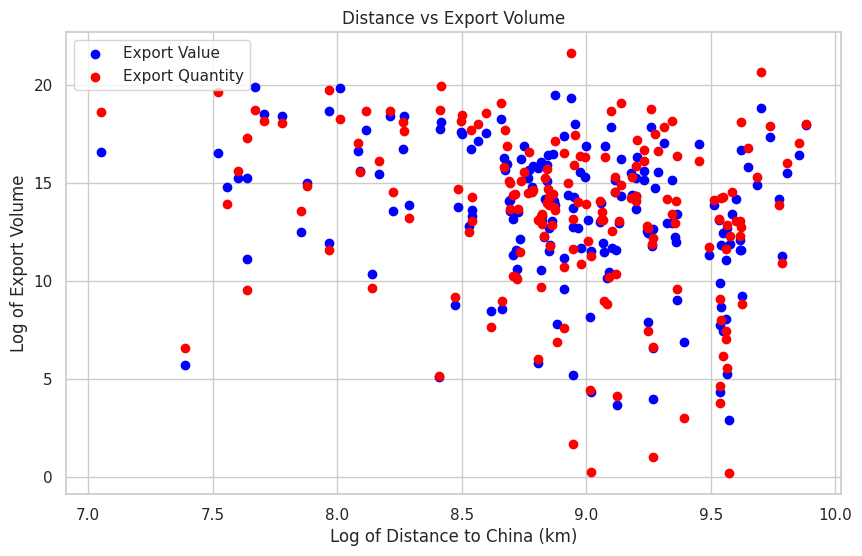

In [ ]:
# 加载贸易数据
data_files = [
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
]
trade_data = dd.read_csv(data_files, dtype={'i': 'str', 'j': 'str', 'k': 'object'}, encoding='ISO-8859-1')

# 加载国家代码数据
country_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/country_codes_V202001.csv'
country_codes = pd.read_csv(country_codes_path, encoding='ISO-8859-1')
country_codes['country_code'] = country_codes['country_code'].astype(str)  # 确保为字符串类型

# 过滤出向中国的出口数据
trade_data_to_china = trade_data[trade_data['j'] == '156']  # 中国的三位代码
export_summary = trade_data_to_china.groupby('i').agg({'v': 'sum', 'q': 'sum'}).compute().reset_index()

# 将出口数据与国家代码和距离数据合并
# 需要使用 iso_n3 作为合并键，将合并修改为以下：
export_summary = export_summary.merge(country_codes, left_on='i', right_on='country_code')
export_summary = export_summary.merge(countries[['iso_n3', 'distance_to_china']], left_on='country_code', right_on='iso_n3')

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.log1p(export_summary['distance_to_china']), np.log1p(export_summary['v']), color='blue', label='Export Value')
plt.scatter(np.log1p(export_summary['distance_to_china']), np.log1p(export_summary['q']), color='red', label='Export Quantity')
plt.xlabel('Log of Distance to China (km)')
plt.ylabel('Log of Export Volume')
plt.title('Distance vs Export Volume')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
### 1.4.2 所有国家对中国的进口量与距离之间的关系

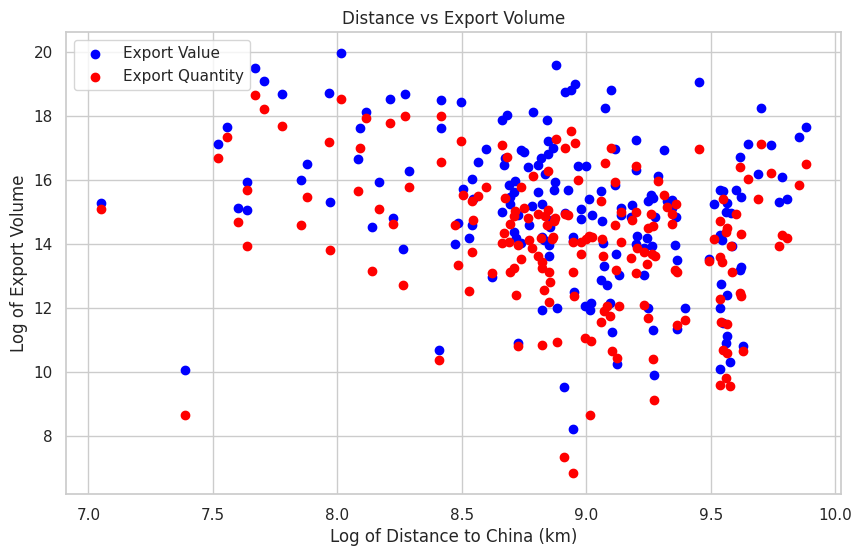

In [ ]:
# 过滤从中国进口的进口数据
trade_data_to_china = trade_data[trade_data['i'] == '156']  # 中国的三位代码
export_summary = trade_data_to_china.groupby('j').agg({'v': 'sum', 'q': 'sum'}).compute().reset_index()

# 将进口数据与国家代码和距离数据合并
# 需要使用 iso_n3 作为合并键，将合并修改为以下：
export_summary = export_summary.merge(country_codes, left_on='j', right_on='country_code')
export_summary = export_summary.merge(countries[['iso_n3', 'distance_to_china']], left_on='country_code', right_on='iso_n3')

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.log1p(export_summary['distance_to_china']), np.log1p(export_summary['v']), color='blue', label='Export Value')
plt.scatter(np.log1p(export_summary['distance_to_china']), np.log1p(export_summary['q']), color='red', label='Export Quantity')
plt.xlabel('Log of Distance to China (km)')
plt.ylabel('Log of Export Volume')
plt.title('Distance vs Export Volume')
plt.legend()
plt.grid(True)
plt.show()

### 2.Unsupervised Learning: Identifying Trade Patterns (40 points in total)

1.Export/Import Values (出口/进口价值):

 特征1：贸易总价值：每个国家的总出口价值+总进口价值

 特征2：出口/进口平衡：出口价值与进口价值的比例，作为国家贸易平衡的指标。

 特征3：贸易稳定性指数：出口和进口波动率的加权平均值-【出口和进口波动率的加权平均值，权重分别是出口额占贸易额的比例和进口额占贸易额的比例】

2.Sectors (行业):

 特征4：主导行业贸易额：每个国家最大的几个行业的贸易额。

 特征5：行业多样性：通过计算每个国家出口&进口行业的熵来衡量其贸易行业的多样性。

 特征6：行业集中度：使用赫芬达尔指数（Herfindahl-Hirschman Index, HHI）来衡量一个国家
 贸易的行业集中度。

3.Distance:
  
  特征7：每个国家贸易伙伴的数量；

  特征8：平均贸易距离：平均出口距离【对于每个国家（作为出口国），计算其向所有进口国出口商品的加权平均距离，权重为贸易额】和平均进口距离【对于每个国家（作为进口国），计算其从所有出口国进口商品的加权平均距离，权重为贸易额】的加权平均

  特征9：最远贸易国家距离；max{最远出口距离，最远进口距离}

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
# 加载国家代码数据，并立即转换为Pandas DataFrame
country_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/country_codes_V202001.csv'
country_codes = dd.read_csv(country_codes_path, encoding='ISO-8859-1').compute()
country_codes['country_code'] = country_codes['country_code'].astype(str)

In [ ]:
import geopandas as gpd
# 加载国家形状文件
shapefile_path = '/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile/cn_primary_countries.shp'
countries = gpd.read_file(shapefile_path).to_crs(epsg=4326)

countries['iso_a3'] = countries['iso_a3'].astype(str)  # 确保为字符串类型
countries['iso_n3'] = countries['iso_n3'].astype(str)  # 确保为字符串类型

In [ ]:
# 加载产品代码数据
product_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/product_codes_HS12_V202001.csv'
product_codes = dd.read_csv(product_codes_path, dtype={'code': 'object'}, encoding='ISO-8859-1').compute()
product_codes = product_codes.dropna(subset=['code'])
# 确保数据类型一致
product_codes['code'] = product_codes['code'].astype(str)

In [ ]:
# 加载贸易数据
data_files = [
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
]

# 使用 Dask 读取数据
trade_data = dd.read_csv(data_files, dtype={'i': 'str', 'j': 'str', 'k': 'object'}, encoding='ISO-8859-1')

# 计算并转换为 Pandas DataFrame
trade_data = trade_data.compute()

# 数据类型转换
trade_data['i'] = trade_data['i'].astype(str)
trade_data['k'] = trade_data['k'].astype(str)
trade_data['j'] = trade_data['j'].astype(str)
trade_data['v'] = trade_data['v'].astype(float)
trade_data['q'] = trade_data['q'].astype(float)

# For特征1: 计算每个国家的总出口额
export_value_country = trade_data.groupby('i')['v'].sum()
export_df = export_value_country.reset_index().rename(columns={'v': 'export_value'})

# For特征1: 计算每个国家的进口总额
import_value_country = trade_data.groupby('j')['v'].sum()
import_df = import_value_country.reset_index().rename(columns={'v': 'import_value', 'j': 'i'})

# 特征2: 计算每个国家的贸易平衡
balance_df = pd.merge(export_df, import_df, on='i', how='outer').fillna(0)
balance_df['balance_ratio'] = balance_df['export_value'] / balance_df['import_value'].replace(0, 1)


In [ ]:
# 特征3：贸易稳定性指数
import dask.dataframe as dd
import pandas as pd
import numpy as np

# 加载贸易数据
data_files = {
    '2016': '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '2017': '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '2018': '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
}

# 使用 Dask 读取数据并分配年份
frames = []
for year, path in data_files.items():
    df = dd.read_csv(path, dtype={'i': 'str', 'j': 'str', 'k': 'object'}, encoding='ISO-8859-1')
    df['year'] = int(year)  # 添加年份列
    frames.append(df)

# 合并所有年份的数据
trade_data2 = dd.concat(frames).compute()

# 数据类型转换
trade_data2['i'] = trade_data2['i'].astype(str)
trade_data2['k'] = trade_data2['k'].astype(str)
trade_data2['j'] = trade_data2['j'].astype(str)
trade_data2['v'] = trade_data2['v'].astype(float)
trade_data2['q'] = trade_data2['q'].astype(float)

# 之后的代码继续处理合并后的 DataFrame
# 例如，计算每个国家每年的出口总额和进口总额
annual_export_values = trade_data2.groupby(['i', 'year'])['v'].sum().reset_index().rename(columns={'v': 'annual_export'})
annual_import_values = trade_data2.groupby(['j', 'year'])['v'].sum().reset_index().rename(columns={'j': 'i', 'v': 'annual_import'})

# 合并年度出口进口数据
annual_values = pd.merge(annual_export_values, annual_import_values, on=['i', 'year'], how='outer').fillna(0)

# 定义贸易稳定性指数计算函数，并应用
def trade_fluctuation(df):
    # 计算出口和进口的波动率
    export_fluctuation = df['annual_export'].std() / df['annual_export'].mean() if len(df['annual_export']) > 1 else 0
    import_fluctuation = df['annual_import'].std() / df['annual_import'].mean() if len(df['annual_import']) > 1 else 0

    # 计算总贸易额和权重
    trade_total = df['annual_export'].mean() + df['annual_import'].mean()
    export_weight = df['annual_export'].mean() / trade_total if trade_total > 0 else 0
    import_weight = df['annual_import'].mean() / trade_total if trade_total > 0 else 0

    # 计算各自的稳定性指数
    export_stability_index = export_fluctuation * export_weight
    import_stability_index = import_fluctuation * import_weight
    total_stability_index = export_stability_index + import_stability_index

    return pd.Series({
        'export_stability_index': export_stability_index,
        'import_stability_index': import_stability_index,
        'total_stability_index': total_stability_index
    })

# 应用函数并生成结果 DataFrame
stability_index_df = annual_values.groupby('i').apply(trade_fluctuation).reset_index()

stability_index_df.head()

,i,export_stability_index,import_stability_index,total_stability_index
0,100,0.054730,0.065919,0.120649
1,104,0.052967,0.050263,0.103230
2,108,0.034514,0.079185,0.113699
3,112,0.084775,0.085175,0.169950
4,116,0.019569,0.079309,0.098877


In [ ]:
# 特征4：主导行业出口额&进口额&贸易额
# 出口额的计算
industry_export = trade_data.groupby(['i', 'k'])['v'].sum().reset_index()
total_export_by_country = industry_export.groupby('i')['v'].sum().reset_index().rename(columns={'v': 'total_export'})
industry_export = pd.merge(industry_export, total_export_by_country, on='i')
# 计算进口额
industry_import = trade_data.groupby(['j', 'k'])['v'].sum().reset_index().rename(columns={'j': 'i', 'v': 'import_value'})
total_import_by_country = industry_import.groupby('i')['import_value'].sum().reset_index().rename(columns={'import_value': 'total_import'})
industry_import = pd.merge(industry_import, total_import_by_country, on='i')
# 合并行业出口和进口数据
industry_trade = pd.merge(industry_export, industry_import, on=['i', 'k'], how='outer').fillna(0)
industry_trade['total_trade'] = industry_trade['v'] + industry_trade['import_value']
# 计算每个国家前五个主导行业的贸易额总和
def top_industries(df):
    top_industries = df.nlargest(5, 'v')
    top_export_sum = top_industries['v'].sum()
    top_import_sum = top_industries['import_value'].sum()
    top_trade_sum = top_industries['total_trade'].sum()
    return pd.Series({
        'top_five_export': top_export_sum,
        'top_five_import': top_import_sum,
        'top_five_trade': top_trade_sum
    })

top_five_industries_df = industry_trade.groupby('i').apply(top_industries).reset_index()

top_five_industries_df.head()

,i,top_five_export,top_five_import,top_five_trade
0,100,1.625314e+07,5.682878e+06,2.193602e+07
1,104,2.249392e+07,9.797009e+03,2.250372e+07
2,108,5.669954e+05,5.028989e+03,5.720244e+05
3,112,2.903915e+07,1.902839e+07,4.806753e+07
4,116,1.212615e+07,1.839932e+05,1.231015e+07


In [ ]:
# 特征5：行业多样性 - 行业信息熵（出口&进口&贸易）
# Continuing from your existing code where industry_trade DataFrame is created
# Calculate the proportion and entropy for exports, imports, and total trade
industry_export['export_proportion'] = industry_export['v'] / industry_export['total_export']
industry_export['export_entropy'] = -industry_export['export_proportion'] * np.log(industry_export['export_proportion'] + 1e-10)
export_entropy = industry_export.groupby('i')['export_entropy'].sum().reset_index()

industry_import['import_proportion'] = industry_import['import_value'] / industry_import['total_import']
industry_import['import_entropy'] = -industry_import['import_proportion'] * np.log(industry_import['import_proportion'] + 1e-10)
import_entropy = industry_import.groupby('i')['import_entropy'].sum().reset_index()

industry_trade['total_proportion'] = industry_trade['total_trade'] / industry_trade.groupby('i')['total_trade'].transform('sum')
industry_trade['total_entropy'] = -industry_trade['total_proportion'] * np.log(industry_trade['total_proportion'] + 1e-10)
total_trade_entropy = industry_trade.groupby('i')['total_entropy'].sum().reset_index()

# Merge entropy calculations into a single DataFrame
entropy_df = pd.merge(export_entropy, import_entropy, on='i', how='outer')
entropy_df = pd.merge(entropy_df, total_trade_entropy, on='i', how='outer')
entropy_df.columns = ['i', 'export_entropy', 'import_entropy', 'total_entropy']

entropy_df.head()

,i,export_entropy,import_entropy,total_entropy
0,100,6.097845,6.348692,6.485653
1,104,4.341105,6.104052,5.948190
2,108,2.408483,5.305136,5.105021
3,112,5.149465,5.919983,5.907728
4,116,4.694042,5.479076,5.710161


In [ ]:
# 特征6: 行业集中度 - 赫芬达尔指数 (HHI)
# Calculate the proportion and HHI for exports
industry_export['export_proportion'] = industry_export['v'] / industry_export['total_export']
industry_export['export_HHI'] = industry_export['export_proportion'] ** 2
export_hhi_df = industry_export.groupby('i')['export_HHI'].sum().reset_index()

# Calculate the proportion and HHI for imports
industry_import['import_proportion'] = industry_import['import_value'] / industry_import['total_import']
industry_import['import_HHI'] = industry_import['import_proportion'] ** 2
import_hhi_df = industry_import.groupby('i')['import_HHI'].sum().reset_index()

# Total trade HHI using weights based on trade values
# Calculate weighted proportions for total trade HHI
industry_trade['export_weighted_proportion'] = (industry_trade['v'] / industry_trade['total_export']) * (industry_trade['total_export'] / (industry_trade['total_export'] + industry_trade['total_import']))
industry_trade['import_weighted_proportion'] = (industry_trade['import_value'] / industry_trade['total_import']) * (industry_trade['total_import'] / (industry_trade['total_export'] + industry_trade['total_import']))
industry_trade['total_weighted_proportion'] = industry_trade['export_weighted_proportion'] + industry_trade['import_weighted_proportion']

# Calculate HHI for total trade
industry_trade['total_HHI'] = industry_trade['total_weighted_proportion'] ** 2
total_hhi_df = industry_trade.groupby('i')['total_HHI'].sum().reset_index()

# Merge HHI calculations into a single DataFrame
hhi_df = pd.merge(export_hhi_df, import_hhi_df, on='i', how='outer')
hhi_df = pd.merge(hhi_df, total_hhi_df, on='i', how='outer')
hhi_df.columns = ['i', 'export_HHI', 'import_HHI', 'total_HHI']

hhi_df.head()

,i,export_HHI,import_HHI,total_HHI
0,100,0.009727,0.013131,0.007724
1,104,0.062217,0.016642,0.017050
2,108,0.214500,0.033112,0.021062
3,112,0.046148,0.035508,0.023520
4,116,0.018476,0.027701,0.012352


In [ ]:
# 特征7: 贸易伙伴数量
export_partners_df = trade_data.groupby('i')['j'].nunique().reset_index().rename(columns={'j': 'export_partner_count'})
import_partners_df = trade_data.groupby('j')['i'].nunique().reset_index().rename(columns={'j': 'i', 'i': 'import_partner_count'})
partner_count_df = pd.merge(export_partners_df, import_partners_df, on='i', how='outer').fillna(0)
# 计算每个国家的总贸易伙伴数量
partner_count_df['total_partner_count'] = partner_count_df['export_partner_count'] + partner_count_df['import_partner_count']

partner_count_df.head()

,i,export_partner_count,import_partner_count,total_partner_count
0,100,196,174.0,370.0
1,104,179,189.0,368.0
2,108,106,140.0,246.0
3,112,176,183.0,359.0
4,116,161,133.0,294.0


In [ ]:
# 特征8：平均贸易距离（平均出口距离和平均进口距离的加权）
# 8.1平均出口距离：对于每个国家（作为出口国），计算其向所有进口国出口商品的加权平均距离，权重为贸易额
# 8.2：平均进口距离：对于每个国家（作为进口国），计算其从所有出口国进口商品的加权平均距离，权重为贸易额。

In [ ]:
import dask.dataframe as dd

# 加载贸易数据
data_files = [
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2016_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2017_V202001.csv',
    '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/BACI_HS12_Y2018_V202001.csv'
]

trade_data3 = dd.read_csv(data_files, dtype={'i': 'str', 'j': 'str', 'k': 'object'}, encoding='ISO-8859-1')
# 将 Dask DataFrame 转换为 Pandas DataFrame，如果数据量非常大，这一步需要谨慎操作
trade_data_pd = trade_data3.compute()
# 国家代码列表从 GeoDataFrame 中获取
countries_codes = countries.index.tolist()
# 查找在 trade_data['i'] 中但不在 countries_codes 中的唯一国家代码
missing_codes = trade_data_pd[~trade_data_pd['i'].isin(countries_codes)]['i'].unique()
# 计算这些代码的数量
missing_count = len(missing_codes)
print(f"Number of country codes in 'i' that are not in 'iso_n3': {missing_count}")
print("Missing country codes:", missing_codes)

Number of country codes in 'i' that are not in 'iso_n3': 222
Missing country codes: <ArrowStringArray>
[  '4',   '8',  '12',  '16',  '20',  '24',  '28',  '31',  '32',  '36',
 ...
 '842', '854', '858', '860', '862', '876', '882', '887', '894', '530']
Length: 222, dtype: string


In [ ]:
# 查找在 trade_data['i'] 中但不在 countries_codes 中的唯一国家代码
missing_codes = trade_data_pd[~trade_data_pd['j'].isin(countries_codes)]['i'].unique()
# 计算这些代码的数量
missing_count = len(missing_codes)
print(f"Number of country codes in 'j' that are not in 'iso_n3': {missing_count}")
print("Missing country codes:", missing_codes)

Number of country codes in 'j' that are not in 'iso_n3': 222
Missing country codes: <ArrowStringArray>
[  '4',   '8',  '12',  '16',  '20',  '24',  '28',  '31',  '32',  '36',
 ...
 '842', '854', '858', '860', '862', '876', '882', '887', '894', '530']
Length: 222, dtype: string


In [ ]:
# 步骤 1: 准备国家的经纬度数据
import geopandas as gpd
import numpy as np
import pandas as pd

# 加载国家形状文件
countries = gpd.read_file('/content/drive/MyDrive/ipen5810_miniproject2/countries_shapefile/cn_primary_countries.shp')
countries['iso_n3'] = countries['iso_n3'].astype(str)
countries['lon'] = countries.geometry.centroid.x
countries['lat'] = countries.geometry.centroid.y
countries.set_index('iso_n3', inplace=True)
# 创建经纬度的DataFrame
coords = countries[['lon', 'lat']]

<ipython-input-27-6cd73f7845bd>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries['lon'] = countries.geometry.centroid.x
<ipython-input-27-6cd73f7845bd>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries['lat'] = countries.geometry.centroid.y


In [ ]:
# 步骤 2: 应用Haversine函数来计算国家间距离矩阵
# 定义Haversine函数
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # 地球半径 (公里)
    return c * r

# 计算距离矩阵
def compute_distances(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = haversine(coords.iloc[i]['lon'], coords.iloc[i]['lat'],
                                          coords.iloc[j]['lon'], coords.iloc[j]['lat'])
    return dist_matrix

# 应用函数
dist_matrix = compute_distances(coords)
dist_df = pd.DataFrame(dist_matrix, index=countries.index, columns=countries.index)
dist_df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/distance_matrix.csv', index=False)

In [ ]:
import dask.dataframe as dd
import pandas as pd
# 确保只包括 dist_df 中有的国家代码
valid_exporters = trade_data['i'].isin(dist_df.index)
valid_importers = trade_data['j'].isin(dist_df.columns)
trade_data_clean = trade_data[valid_exporters & valid_importers]

# 计算平均出口和进口距离的函数
def weighted_export_distance(df, distances):
    total_weighted_distance = 0
    total_value = 0

    for _, row in df.iterrows():
        exporter = row['i']
        importer = row['j']
        trade_value = row['v']
        if exporter in distances.index and importer in distances.columns:
            distance = distances.at[exporter, importer]
            total_weighted_distance += trade_value * distance
            total_value += trade_value

    return total_weighted_distance / total_value if total_value != 0 else None

def weighted_import_distance(df, distances):
    total_weighted_distance = 0
    total_value = 0

    for _, row in df.iterrows():
        importer = row['j']
        exporter = row['i']
        trade_value = row['v']
        if importer in distances.index and exporter in distances.columns:
            distance = distances.at[importer, exporter]
            total_weighted_distance += trade_value * distance
            total_value += trade_value

    return total_weighted_distance / total_value if total_value != 0 else None

# 使用 Pandas 进行分组和应用函数
export_distances = trade_data_clean.groupby('i').apply(lambda df: weighted_export_distance(df, dist_df))
import_distances = trade_data_clean.groupby('j').apply(lambda df: weighted_import_distance(df, dist_df))

export_distances_df = export_distances.reset_index().rename(columns={0: 'export_distance'})
import_distances_df = import_distances.reset_index().rename(columns={0: 'import_distance', 'j': 'i'})

# Merge the export and import distance DataFrames on the country code 'i'
average_distance_df = pd.merge(export_distances_df, import_distances_df, on='i', how='outer')

# Rename columns if necessary (assuming the merge didn't require renaming, given the preparation above)
average_distance_df.columns = ['i', 'average_export_distance', 'average_import_distance']

average_distance_df.head()



,i,average_export_distance,average_import_distance
0,100,2026.222929,2466.640434
1,104,2954.802982,2461.786001
2,108,4017.028330,4568.927439
3,112,3013.501504,3503.760258
4,116,6777.334518,1844.676396


In [ ]:
# For特征9：最远贸易国家距离
# 9.1 最远进口国距离
import pandas as pd
from tqdm import tqdm  # 引入 tqdm

# 1. 提取每个进口国与其所有出口国的距离
def max_import_distance(importer, data, distances):
    # 提取与该进口国相关的所有出口国
    exporters = data[data['j'] == importer]['i'].unique()
    # 查找这些出口国的最大距离
    max_distance = distances.loc[exporters, importer].max()  # 确保这里没有语法错误
    return max_distance

# 2. 对每个进口国应用上述函数
farthest_import_distances = trade_data_clean['j'].unique()
progress_bar = tqdm(farthest_import_distances)  # 包装迭代器以显示进度条
farthest_import_distances = {importer: max_import_distance(importer, trade_data_clean, dist_df) for importer in progress_bar}

# 3. 转换为 DataFrame
farthest_import_distances_df = pd.DataFrame(list(farthest_import_distances.items()), columns=['j', 'farthest_import_distance'])
# 重命名 'j' 列为 'i'
farthest_import_distances_df.rename(columns={'j': 'i'}, inplace=True)

farthest_import_distances_df.head()


100%|██████████| 178/178 [02:12<00:00,  1.34it/s]


,i,farthest_import_distance
0,12,18327.016527
1,24,16955.128420
2,32,19017.498882
3,36,18089.008551
4,40,18121.667967


In [ ]:
# For特征9：最远贸易国家距离
# 9.2 最远出口国距离

# 1. 提取每个出口国与其所有进口国的距离
def max_export_distance(exporter, data, distances):
    # 提取与该出口国相关的所有进口国
    importers = data[data['i'] == exporter]['j'].unique()
    # 查找这些进口国的最大距离
    max_distance = distances.loc[exporter, importers].max()
    return max_distance

# 2. 对每个出口国应用上述函数
farthest_export_distances = trade_data_clean['i'].unique()
progress_bar = tqdm(farthest_export_distances)  # 包装迭代器以显示进度条
farthest_export_distances = {exporter: max_export_distance(exporter, trade_data_clean, dist_df) for exporter in progress_bar}

# 3. 转换为 DataFrame
farthest_export_distances_df = pd.DataFrame(list(farthest_export_distances.items()), columns=['i', 'farthest_export_distance'])

farthest_export_distances_df.head()

# Merge the farthest import and export distance DataFrames on the country code 'i'
farthest_distances_df = pd.merge(farthest_import_distances_df, farthest_export_distances_df, on='i', how='outer')

# Rename columns if necessary to make them more descriptive
farthest_distances_df.columns = ['i', 'farthest_import_distance', 'farthest_export_distance']

farthest_distances_df.head()


100%|██████████| 178/178 [02:11<00:00,  1.35it/s]


,i,farthest_import_distance,farthest_export_distance
0,12,18327.016527,18187.924097
1,24,16955.128420,16955.128420
2,32,19017.498882,19017.498882
3,36,18089.008551,18089.008551
4,40,18121.667967,18121.667967


In [ ]:
print(len(export_df))
print(len(import_df))
print(len(balance_df))
print(len(stability_index_df))

print(len(top_five_industries_df))
print(len(entropy_df))
print(len(hhi_df))
print(len(partner_count_df))

print(len(average_distance_df))
print(len(farthest_distances_df))

222
221
222
222
222
222
222
222
178
178


In [ ]:
print(export_df.columns)
print(import_df.columns)
print(balance_df.columns)
print(stability_index_df.columns)

print(top_five_industries_df.columns)
print(entropy_df.columns)
print(hhi_df.columns)
print(partner_count_df.columns)

print(average_distance_df.columns)
print(farthest_distances_df.columns)


Index(['i', 'export_value'], dtype='object')
Index(['i', 'import_value'], dtype='object')
Index(['i', 'export_value', 'import_value', 'balance_ratio'], dtype='object')
Index(['i', 'export_stability_index', 'import_stability_index',
       'total_stability_index'],
      dtype='object')
Index(['i', 'top_five_export', 'top_five_import', 'top_five_trade'], dtype='object')
Index(['i', 'export_entropy', 'import_entropy', 'total_entropy'], dtype='object')
Index(['i', 'export_HHI', 'import_HHI', 'total_HHI'], dtype='object')
Index(['i', 'export_partner_count', 'import_partner_count',
       'total_partner_count'],
      dtype='object')
Index(['i', 'average_export_distance', 'average_import_distance'], dtype='object')
Index(['i', 'farthest_import_distance', 'farthest_export_distance'], dtype='object')


In [ ]:
# 将所有特征 DataFrame 根据 'i' 列合并，以 export_df 为基础
final_df = export_df.merge(import_df, on='i', how='left')
final_df = final_df.merge(balance_df, on='i', how='left')
final_df = final_df.merge(stability_index_df, on='i', how='left')
final_df = final_df.merge(top_five_industries_df, on='i', how='left')
final_df = final_df.merge(entropy_df, on='i', how='left')
final_df = final_df.merge(hhi_df, on='i', how='left')
final_df = final_df.merge(partner_count_df, on='i', how='left')
final_df = final_df.merge(average_distance_df, on='i', how='left')
final_df = final_df.merge(farthest_distances_df, on='i', how='left')
# 删除 'export_value_y' 和 'import_value_y' 这两列
final_df = final_df.drop(columns=['export_value_y', 'import_value_y'])
final_df = final_df.rename(columns={'export_value_x': 'export_value'})
final_df = final_df.rename(columns={'import_value_x': 'import_value'})
final_df.head()

NameError: name 'export_df' is not defined

In [ ]:
# 补充一些基于final_df计算的一些指标
# 特征8：
# 计算出口和进口的总价值
final_df['total_trade_value'] = final_df['export_value'] + final_df['import_value']
# 避免除以零，处理总贸易额为零的情况
final_df['total_trade_value'] = final_df['total_trade_value'].replace(0, 1)
# 计算权重
final_df['export_weight'] = final_df['export_value'] / final_df['total_trade_value']
final_df['import_weight'] = final_df['import_value'] / final_df['total_trade_value']
# 计算加权平均贸易距离
final_df['average_trade_distance'] = (final_df['average_export_distance'] * final_df['export_weight'] +
                                      final_df['average_import_distance'] * final_df['import_weight'])

# 特征9: 增加列 farthest_trade_distance，它是 farthest_export_distance 和 farthest_import_distance 中的最大值
final_df['farthest_trade_distance'] = final_df[['farthest_export_distance', 'farthest_import_distance']].max(axis=1)

final_df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/features_combine_comprehensive.csv', index=False)

In [ ]:
len(final_df)

In [ ]:
# 删除包含任何缺失值的行
final_df = final_df.dropna()
len(final_df)

In [ ]:
# 删除包含任何缺失值的行
final_df = final_df.dropna()

# 输出结果，查看 DataFrame 结构
final_df.head()
final_df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/features_combine.csv', index=False)

In [ ]:
final_df.head()

,i,export_value,import_value,balance_ratio,export_stability_index,import_stability_index,total_stability_index,top_five_export,top_five_import,top_five_trade,...,total_partner_count,average_export_distance,average_import_distance,farthest_import_distance,farthest_export_distance,total_trade_value,export_weight,import_weight,average_trade_distance,farthest_trade_distance
0,100,9.146465e+07,1.012442e+08,0.903406,0.054730,0.065919,0.120649,1.625314e+07,5.682878e+06,2.193602e+07,...,370.0,2026.222929,2466.640434,17256.211812,17256.211812,1.927088e+08,0.474626,0.525374,2257.606780,17256.211812
1,104,5.314178e+07,7.513492e+07,0.707285,0.052967,0.050263,0.103230,2.249392e+07,9.797009e+03,2.250372e+07,...,368.0,2954.802982,2461.786001,18359.588773,18359.588773,1.282767e+08,0.414275,0.585725,2666.030420,18359.588773
2,108,7.275871e+05,2.359766e+06,0.308330,0.034514,0.079185,0.113699,5.669954e+05,5.028989e+03,5.720244e+05,...,246.0,4017.028330,4568.927439,14424.132667,14424.132667,3.087353e+06,0.235667,0.764333,4438.863061,14424.132667
3,112,8.474673e+07,9.630272e+07,0.880004,0.084775,0.085175,0.169950,2.903915e+07,1.902839e+07,4.806753e+07,...,359.0,3013.501504,3503.760258,17027.579755,17027.579755,1.810495e+08,0.468086,0.531914,3274.276944,17027.579755
4,116,5.635553e+07,6.247636e+07,0.902030,0.019569,0.079309,0.098877,1.212615e+07,1.839932e+05,1.231015e+07,...,294.0,6777.334518,1844.676396,19611.396805,19611.396805,1.188319e+08,0.474246,0.525754,4183.969080,19611.396805


In [ ]:
# 出口相关-为了第三问
# 选择并保留特定列
columns_to_keep = [
    'i',
    'export_value',
    'balance_ratio',
    'export_stability_index',
    'top_five_export',
    'export_entropy',
    'export_HHI',
    'export_partner_count',
    'average_export_distance',
    'farthest_export_distance'
]

# 创建 new_df 为 final_df 中选定列的子集
filter_df = final_df[columns_to_keep]

filter_df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/features_combine_exportFor3.csv', index=False)

已经生成所有特征，接下来进行k-means聚类

In [ ]:
import pandas as pd

# 定义文件路径
file_path = '/content/drive/MyDrive/ipen5810_miniproject2/features_combine.csv'

# 读取CSV文件
new_df = pd.read_csv(file_path)
new_df.columns

Index(['i', 'export_value', 'import_value', 'balance_ratio',
       'export_stability_index', 'import_stability_index',
       'total_stability_index', 'top_five_export', 'top_five_import',
       'top_five_trade', 'export_entropy', 'import_entropy', 'total_entropy',
       'export_HHI', 'import_HHI', 'total_HHI', 'export_partner_count',
       'import_partner_count', 'total_partner_count',
       'average_export_distance', 'average_import_distance',
       'farthest_import_distance', 'farthest_export_distance',
       'total_trade_value', 'export_weight', 'import_weight',
       'average_trade_distance', 'farthest_trade_distance'],
      dtype='object')

In [ ]:
# 所有特征
all_features = ['i',
    'export_value', 'import_value', 'balance_ratio',
       'export_stability_index', 'import_stability_index',
       'total_stability_index', 'top_five_export', 'top_five_import',
       'top_five_trade', 'export_entropy', 'import_entropy', 'total_entropy',
       'export_HHI', 'import_HHI', 'total_HHI', 'export_partner_count',
       'import_partner_count', 'total_partner_count',
       'average_export_distance', 'average_import_distance',
       'farthest_import_distance', 'farthest_export_distance','export_weight', 'import_weight',
       'total_trade_value', 'average_trade_distance', 'farthest_trade_distance'
]

# 创建 new_df 为 final_df 中选定列的子集
new_df = new_df[all_features]

new_df
new_df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/Features_combine_all_neededfeatures.csv', index=False)

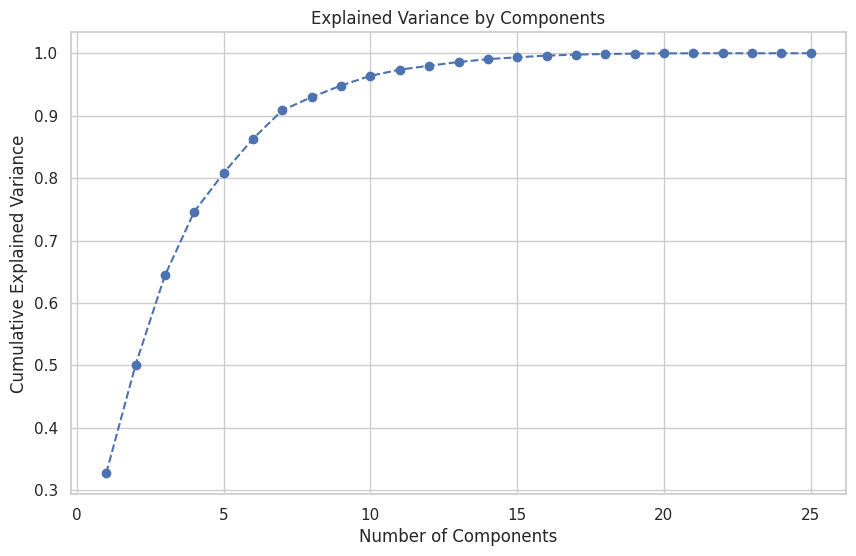

Explained variance by each component:
[3.27192132e-01 1.73755348e-01 1.43175219e-01 1.02162836e-01
 6.19709940e-02 5.48008577e-02 4.55901496e-02 2.11965852e-02
 1.84182367e-02 1.56207285e-02 9.84540338e-03 6.30771325e-03
 5.90471945e-03 4.63226320e-03 2.92453049e-03 2.75570171e-03
 1.53584925e-03 9.95907984e-04 5.57277131e-04 3.96504799e-04
 2.61043161e-04 9.73187828e-33 2.22531446e-33 1.13880354e-33
 7.92576397e-34]


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = new_df

# 选择需要缩放的特征列
# 假设 df 是你的DataFrame
features = df.drop(['i','export_weight','import_weight'], axis=1)  # 去除国家代码列

# 尝试将所有非数值列转换为数值型（这里假设所有列本应为数值型）
features = features.apply(pd.to_numeric, errors='coerce')

# 处理缺失值，这里使用每列的均值填充
features.fillna(features.mean(), inplace=True)

# 数据标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 应用PCA
pca = PCA()
pca.fit(features_scaled)

# 绘制解释的方差比
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# 查看每个成分的贡献
print("Explained variance by each component:")
print(pca.explained_variance_ratio_)


In [ ]:
import numpy as np

# 获取PCA组件的载荷
components = pca.components_

# 打印前四个主要成分的特征载荷
for i in range(4):
    print(f"Component {i+1}:")
    component_loadings = components[i]
    feature_contributions = pd.Series(component_loadings, index=features.columns)
    print(feature_contributions.sort_values(ascending=False))
    print()


Component 1:
export_partner_count        0.291442
export_entropy              0.287335
total_partner_count         0.287259
import_partner_count        0.271908
import_value                0.266799
total_entropy               0.260786
total_trade_value           0.255399
top_five_trade              0.245305
export_value                0.243482
top_five_export             0.227688
top_five_import             0.214085
import_entropy              0.194221
farthest_import_distance    0.111147
farthest_export_distance    0.103524
farthest_trade_distance     0.088085
balance_ratio              -0.001392
average_import_distance    -0.076916
average_trade_distance     -0.106740
export_stability_index     -0.108808
average_export_distance    -0.121950
import_HHI                 -0.125327
import_stability_index     -0.133767
total_HHI                  -0.170524
total_stability_index      -0.172651
export_HHI                 -0.222340
dtype: float64

Component 2:
top_five_export             0.304

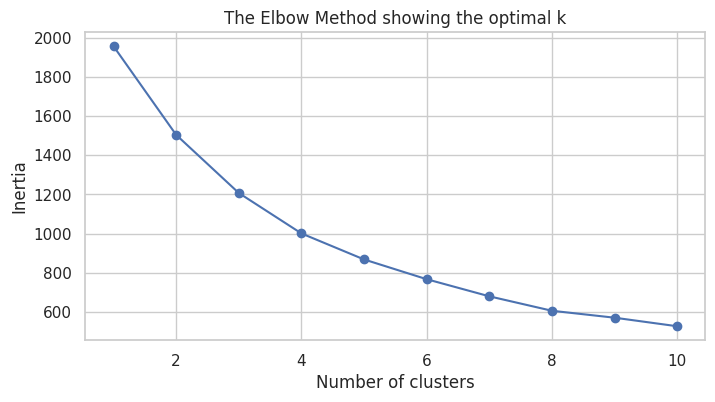

,export_partner_count,export_entropy,total_partner_count,top_five_export,top_five_trade,average_export_distance,farthest_export_distance,farthest_trade_distance,farthest_import_distance,import_HHI,balance_ratio
Cluster,,,,,,,,,,,
0,100.479167,2.511735,202.062500,8.128519e+06,9.898626e+06,7032.684298,18438.297812,18580.759667,18247.293121,0.052378,0.702013
1,123.133333,2.571649,254.844444,2.751261e+07,2.858664e+07,4916.451163,15330.274257,15691.164917,15539.219255,0.016862,1.030503
2,182.849315,4.938054,362.767123,4.263854e+07,5.592613e+07,4449.711073,18126.283257,18171.209775,18134.309729,0.015238,0.801369
3,209.083333,5.199239,419.166667,4.695497e+08,5.919524e+08,5334.511793,17689.149218,17693.938683,17693.938683,0.011960,1.198959


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 选定的特征
selected_features = ['export_partner_count', 'export_entropy', 'total_partner_count',
                     'top_five_export', 'top_five_trade', 'average_export_distance',
                     'farthest_export_distance', 'farthest_trade_distance', 'farthest_import_distance',
                     'import_HHI', 'balance_ratio']

# 提取这些特征
data_for_clustering = df[selected_features]

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# 使用肘部方法确定最佳聚类数
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# 绘制肘部图
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# 根据肘部图选择聚类数目，假设选择了K
K = 4  # 例如这里选择了4作为聚类数
kmeans = KMeans(n_clusters=K, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# 将聚类结果添加到原始DataFrame
df['Cluster'] = clusters

# 分析聚类结果
df.groupby('Cluster')[selected_features].mean()  # 查看每个聚类中心的特征均值


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 假设 data_for_clustering 已经定义
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# 转换标准化后的数据回DataFrame
scaled_df = pd.DataFrame(data_scaled, columns=selected_features)

# 执行聚类
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
scaled_df['Cluster'] = clusters

# 查看每个聚类中心的标准化特征均值
cluster_means_scaled = scaled_df.groupby('Cluster').mean()
cluster_means_scaled


,export_partner_count,export_entropy,total_partner_count,top_five_export,top_five_trade,average_export_distance,farthest_export_distance,farthest_trade_distance,farthest_import_distance,import_HHI,balance_ratio
Cluster,,,,,,,,,,,
0,-0.992695,-0.742545,-1.013911,-0.358084,-0.375624,0.610530,0.607337,0.643038,0.505084,0.611154,-0.244523
1,-0.512474,-0.705203,-0.443904,-0.219706,-0.263918,-0.145572,-1.350363,-1.296011,-1.275296,-0.194700,0.266133
2,0.753381,0.769680,0.721582,-0.111725,-0.100499,-0.312332,0.410803,0.368211,0.430805,-0.231546,-0.090068
3,1.309488,0.932466,1.330657,2.935895,3.103555,0.003795,0.135459,0.047941,0.141290,-0.305922,0.528006


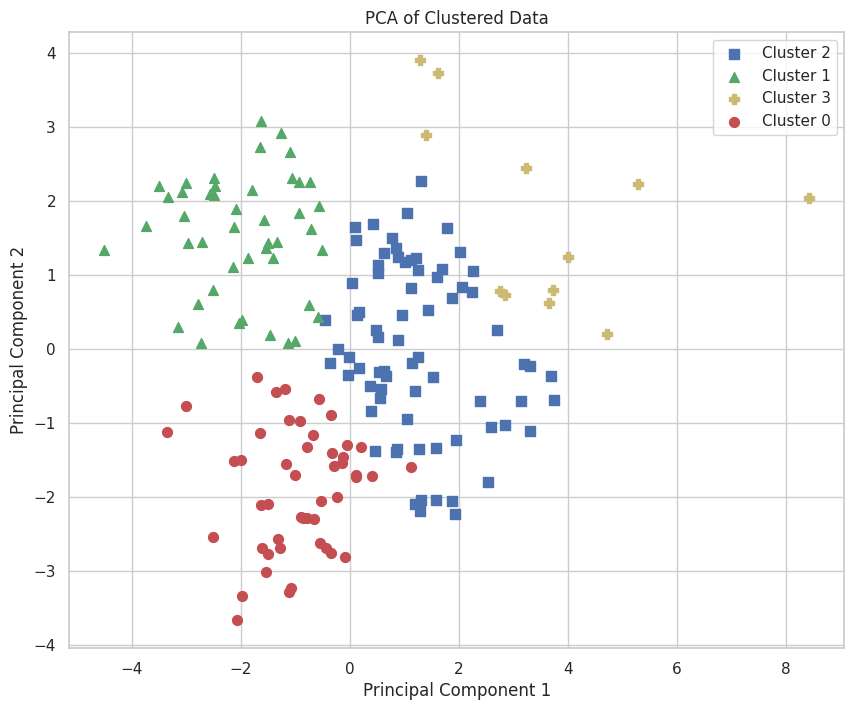

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 已经有了data_scaled（标准化的数据）和clusters（聚类结果）

# 应用PCA将数据降至二维
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# 创建一个DataFrame来存储主成分数据和聚类标签
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = clusters

# 绘制PCA结果
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # 可以根据实际聚类数调整颜色
markers = ['o', '^', 's', 'P', '*', '+', 'x']  # 不同聚类使用不同的标记

for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Principal Component 1'], cluster_data['Principal Component 2'],
                c=colors[cluster], label=f'Cluster {cluster}', marker=markers[cluster], s=50)
plt.title('PCA of Clustered Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


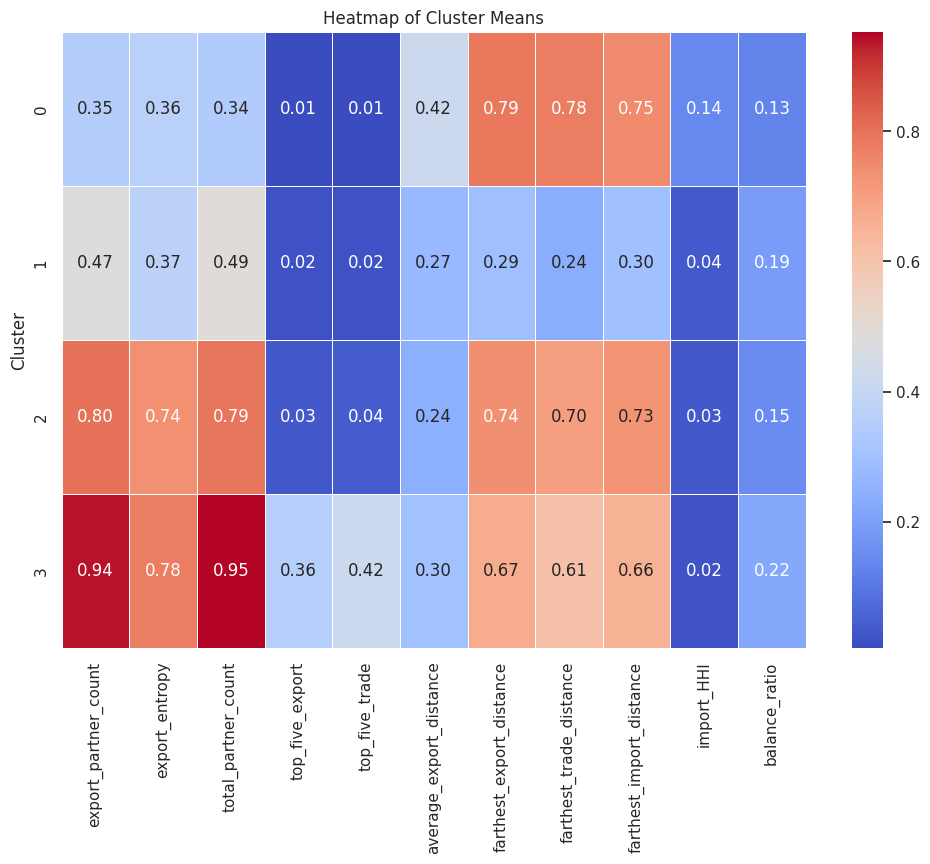

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# 转换标准化后的数据回DataFrame
scaled_df = pd.DataFrame(data_scaled, columns=selected_features)
scaled_df['Cluster'] = clusters  # 添加聚类标签

# 计算每个聚类的标准化特征均值
cluster_means_scaled = scaled_df.groupby('Cluster').mean()

# 绘制热力图
plt.figure(figsize=(12, 8))  # 设置图像大小
sns.heatmap(cluster_means_scaled, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Cluster Means')
plt.ylabel('Cluster')
plt.show()


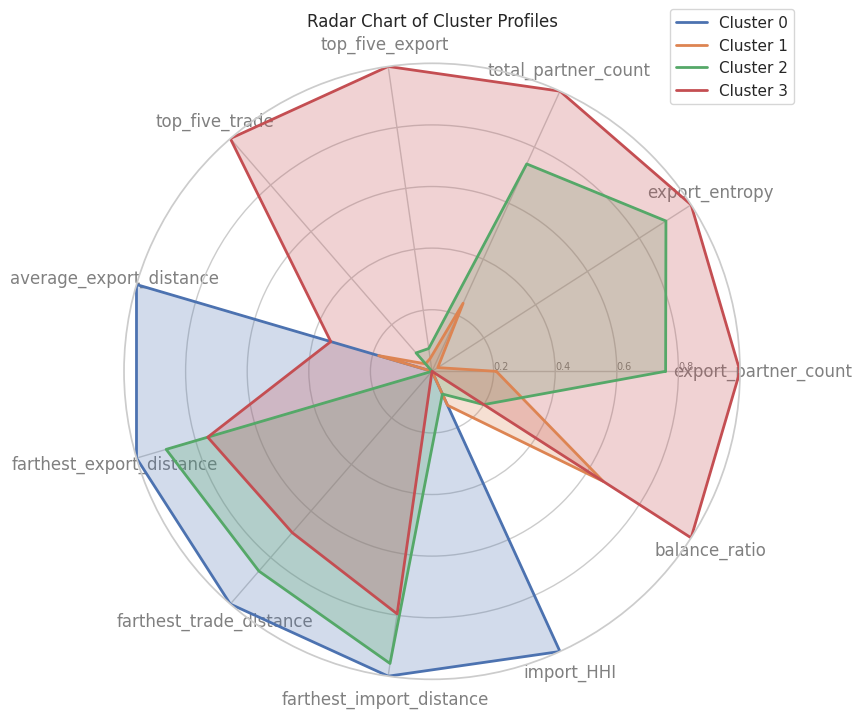

In [ ]:
from math import pi
from math import pi
import matplotlib.pyplot as plt
# 准备雷达图数据
# 计算每个聚类的特征均值
cluster_means = df.groupby('Cluster')[selected_features].mean()
normalized_cluster_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# 设置雷达图的角度
labels = selected_features
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # 闭合雷达图

# 绘制雷达图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in normalized_cluster_means.iterrows():
    data = row.tolist()
    data += data[:1]  # 闭合雷达图数据
    ax.plot(angles, data, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, data, alpha=0.25)

# 设置雷达图的布局
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], labels, color='grey', size=12)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)
plt.title('Radar Chart of Cluster Profiles', position=(0.5, 1.1), ha='center')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
#保存kmeans聚类结果
import dask.dataframe as dd
# 应用 K-means 进行聚类
# 选择一个看似合理的 K 值
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df.drop('i', axis=1))
df[['i','cluster']]
# 确保 'i' 是字符串格式，以匹配 'country_code'
df['i'] = df['i'].astype(str)
# 加载国家代码数据，并立即转换为Pandas DataFrame
country_codes_path = '/content/drive/MyDrive/ipen5810_miniproject2/trade_data/country_codes_V202001.csv'
country_codes = dd.read_csv(country_codes_path, encoding='ISO-8859-1').compute()
country_codes['country_code'] = country_codes['country_code'].astype(str)
# 合并国家名称数据
df = df.merge(country_codes[['country_code', 'country_name_full']], left_on='i', right_on='country_code')
df[['country_name_full','cluster']]
df.to_csv('/content/drive/MyDrive/ipen5810_miniproject2/kmeans_cluster_result.csv', index=False)

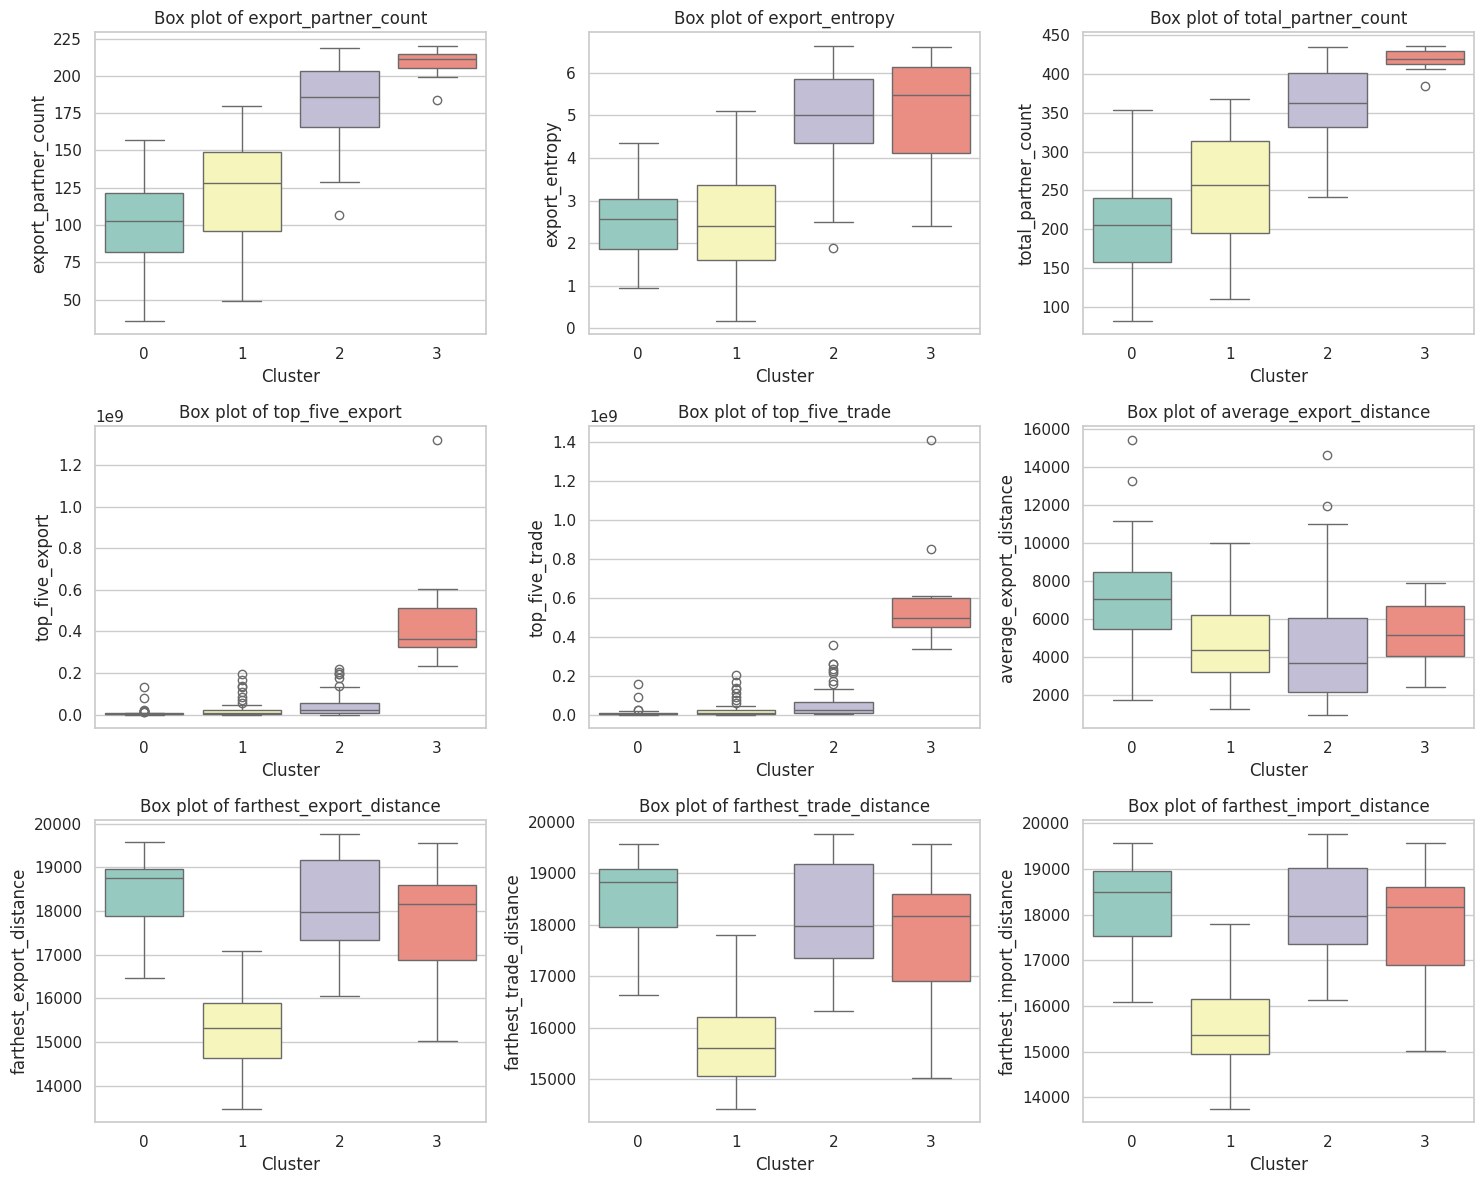

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形风格
sns.set(style="whitegrid")

# 获取你想要绘制的特征列表
selected_features = ['export_partner_count', 'export_entropy', 'total_partner_count',
                     'top_five_export', 'top_five_trade', 'average_export_distance',
                     'farthest_export_distance', 'farthest_trade_distance', 'farthest_import_distance']

# 创建一个图形和子图的数组，每个特征一个子图
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 调整子图布局的行数和列数及大小
axes = axes.flatten()  # 将二维数组展平，便于迭代

# 为每个特征绘制箱形图
for i, feature in enumerate(selected_features):
    sns.boxplot(x='Cluster', y=feature, data=df, ax=axes[i], palette="Set3")
    axes[i].set_title(f'Box plot of {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

# 调整子图之间的间距
plt.tight_layout()
plt.show()


In [ ]:
# 聚合数据，获取每个聚类的国家名称列表和国家数量
cluster_summary = df.groupby('Cluster')['country_name_full'].agg(
    Countries='unique',  # 获取每个聚类的国家名称列表
    Country_Count='nunique'  # 计算每个聚类中的国家数量
)

# 将国家名称的数组转换为字符串，便于在Excel中查看
cluster_summary['Countries'] = cluster_summary['Countries'].apply(lambda x: ', '.join(x))

# 导出DataFrame到Excel文件，使用默认的Excel引擎
cluster_summary.to_excel('/content/drive/MyDrive/ipen5810_miniproject2/Cluster_Summary.xlsx', sheet_name='Cluster Overview')